In [31]:
import pandas as pd
import sys
import os
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
from scipy.stats import zscore
from pydeseq2.default_inference import DefaultInference
from scipy.stats import norm


sys.path.append(os.path.abspath("../../"))
from src.utils.ConvertTextToCsv import TextToCsv
from src.utils.Preprocessing import elimnation_zeros, total_type_len_type_cancer, initialize_DeseqDataSet
from src.utils.plots import PCA_4_scatter_matrix_log2, box_plot, density_plot, histogram_log2, PCA_2_variables, PCA_variables_log2

%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df_clincal_data = pd.read_csv("../../data/raw/brca_tcga_pub2015_clinical_data.tsv", sep='\t')
print(len(df_clincal_data.index))

print(f"Number of rows: {df_clincal_data.shape[0]} and number of columns: {df_clincal_data.shape[1]}")

818
Number of rows: 818 and number of columns: 110


In [3]:
df_clincal_data["Disease Free (Months)"]
df_clincal_data["Disease Free Status"]

0      0:DiseaseFree
1      0:DiseaseFree
2      0:DiseaseFree
3      0:DiseaseFree
4      0:DiseaseFree
           ...      
813    0:DiseaseFree
814    0:DiseaseFree
815    0:DiseaseFree
816    0:DiseaseFree
817              NaN
Name: Disease Free Status, Length: 818, dtype: object

In [4]:
df_clincal_data["Overall Survival (Months)"].unique()
df_clincal_data["Overall Survival Status"].unique()


array(['0:LIVING', '1:DECEASED'], dtype=object)

In [5]:
df_clincal_data["ER Status By IHC"].head(20)

0     Positive
1     Positive
2     Positive
3     Positive
4     Negative
5     Positive
6     Positive
7     Negative
8     Positive
9     Positive
10    Negative
11    Positive
12    Positive
13    Negative
14    Negative
15    Positive
16    Negative
17    Negative
18    Positive
19    Negative
Name: ER Status By IHC, dtype: object

In [6]:
df_clincal_data["PR status by ihc"].head(10)

0    Negative
1    Positive
2    Positive
3    Positive
4    Positive
5    Positive
6    Positive
7    Negative
8    Negative
9    Positive
Name: PR status by ihc, dtype: object

In [7]:
df_clincal_data["HER2 ihc score"].dropna().head(20)

2     1.0
4     2.0
6     2.0
7     0.0
8     3.0
10    0.0
14    2.0
15    2.0
16    2.0
17    1.0
18    2.0
20    3.0
21    1.0
23    1.0
24    0.0
27    2.0
29    2.0
30    2.0
31    2.0
32    1.0
Name: HER2 ihc score, dtype: float64

In [8]:
print(df_clincal_data["HER2 fish status"].isna().sum() / len(df_clincal_data))
print(df_clincal_data["HER2 ihc score"].isna().sum() / len(df_clincal_data))


0.6149144254278729
0.4315403422982885


In [9]:
df_clincal_data["HER2 ihc score"].unique()
df_clincal_data.columns.unique()

Index(['Study ID', 'Patient ID', 'Sample ID', 'Diagnosis Age',
       'American Joint Committee on Cancer Metastasis Stage Code',
       'Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code',
       'Neoplasm Disease Stage American Joint Committee on Cancer Code',
       'American Joint Committee on Cancer Publication Version Type',
       'American Joint Committee on Cancer Tumor Stage Code',
       'Brachytherapy first reference point administered total dose',
       ...
       'Somatic Status', 'Staging System', 'Staging System.1',
       'Surgery for positive margins', 'Surgery for positive margins other',
       'Surgical procedure first', 'Tissue Source Site', 'TMB (nonsynonymous)',
       'Person Neoplasm Status', 'Tumor Disease Anatomic Site'],
      dtype='object', length=110)

In [10]:
list_df = total_type_len_type_cancer(df_clincal_data)
df_clincal_data["Tumor-Cancer"] = list_df

Luminal A: 330 - Total(%): 0.40
Luminal B: 81 - Total(%):0.10
HER2-enriched: 23 - Total(%):0.03
TNBC: 85 - Total(%)0.10 
UNK: 299 - Total(%) 0.37


In [11]:
df_clincal_data["Tumor-Cancer"].unique()

array(['<UNK>', 'Luminal A', 'TNBC', 'Luminal B', 'HER2-enriched'],
      dtype=object)

In [12]:
df_mRNA = pd.read_csv("../../data/raw/data_mrna_seq_v2_rsem.txt", header=None)
df_mRNA_transformed = TextToCsv("../../data/raw/data_mrna_seq_v2_rsem.txt")

Shape of the CSV: (20440, 819)


Clincal Data Set

In [13]:
df_clincal_data["Tumor-Cancer"].unique()

array(['<UNK>', 'Luminal A', 'TNBC', 'Luminal B', 'HER2-enriched'],
      dtype=object)

mRNA seq

In [14]:
df_mRNA_transformed = df_mRNA_transformed.drop(columns=["Hugo_Symbol", "Entrez_Gene_Id"], axis=0)
df_mrna = df_mRNA_transformed.T.reset_index()
df_mRNA_final = df_mrna.rename(columns={"index":"Sample ID"})

Mergin both data sets mRNA-SEQ and Clinical data

In [15]:
df_merged = pd.merge(df_mRNA_final, df_clincal_data, right_on="Sample ID", left_on="Sample ID")

In [16]:
comparation_df = df_merged.loc[
    df_merged["Tumor-Cancer"].isin(["Luminal A", "Luminal B", "TNBC", "HER2-enriched"]),
    ["Tumor-Cancer"] + list(df_merged.columns[1:20441])
]
comparation_df["Tumor-Cancer"].unique()

array(['Luminal A', 'TNBC', 'Luminal B', 'HER2-enriched'], dtype=object)

In [17]:
zeros_reduced_df = elimnation_zeros(comparation_df)

Max of zeros per row in the dataset: 519
Avg of zeros per row in the dataset: 74.00381604696673
Median of zeros per row in the dataset: 0.0
Min of zeros per row in the dataset: 0
After the 0 elimination: 16270


In [18]:
zeros_reduced_df["Tumor-Cancer"].unique()

array(['Luminal A', 'TNBC', 'Luminal B', 'HER2-enriched'], dtype=object)

In [19]:
zeros_reduced_df.iloc[:,1:] = zeros_reduced_df.iloc[:, 1:].astype(int)
print(f"Genes: {zeros_reduced_df.shape[0]}, Samples: {zeros_reduced_df.shape[1]}")

Genes: 519, Samples: 16270


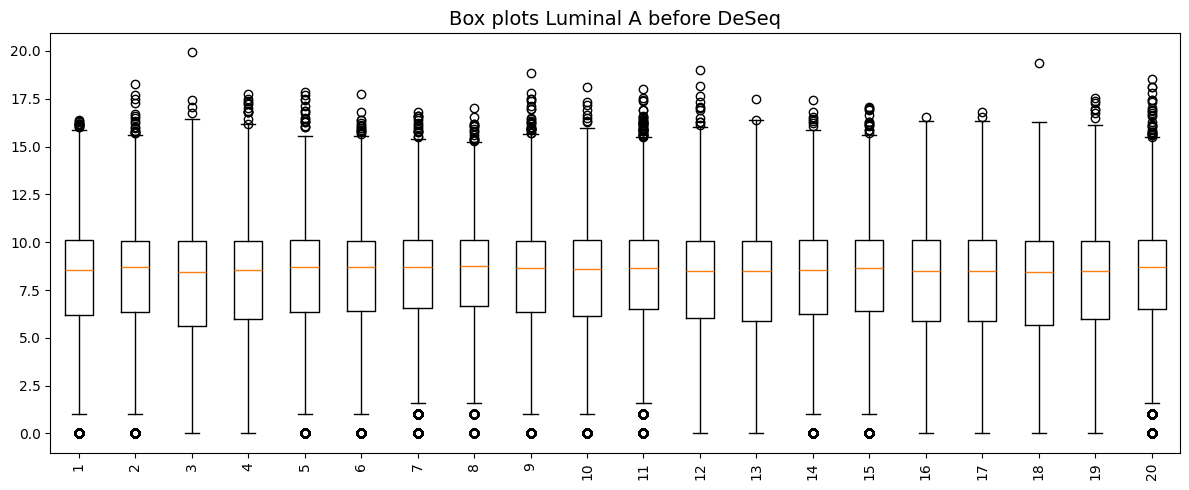

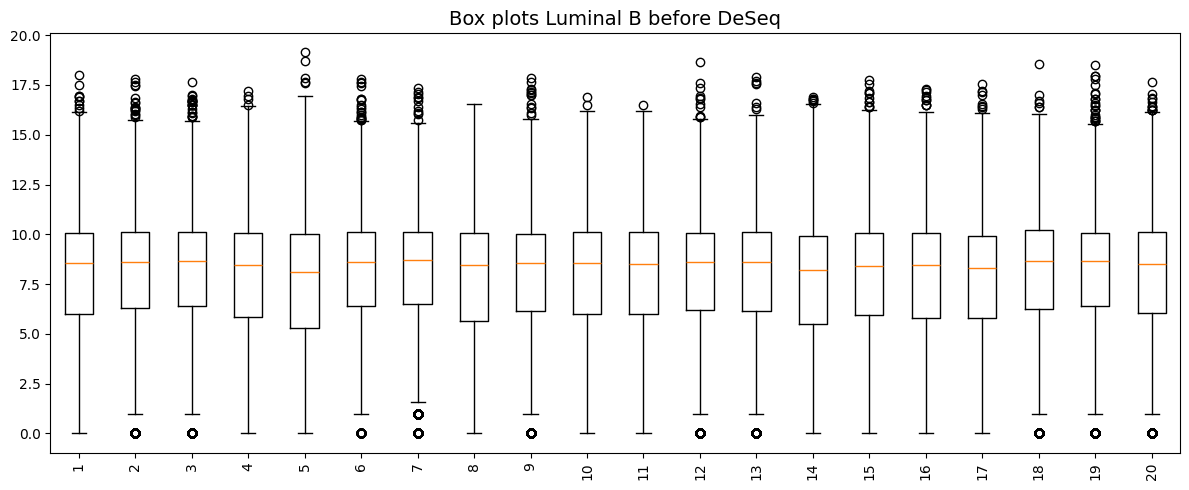

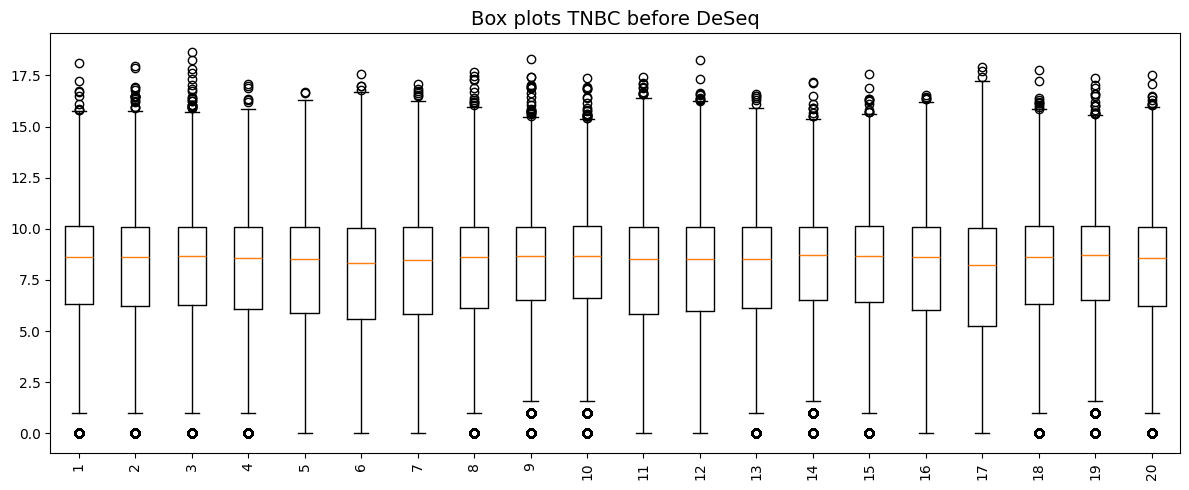

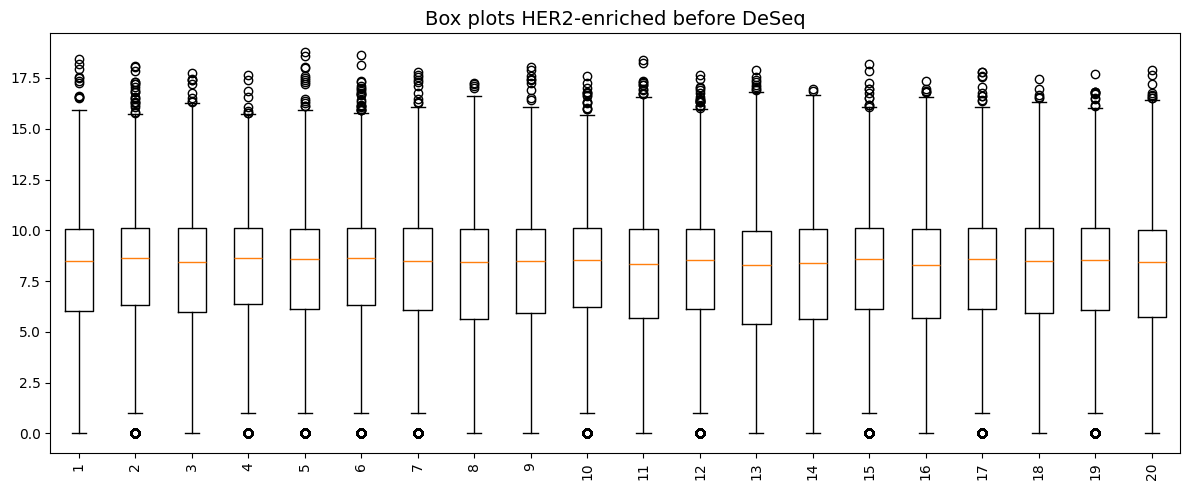

In [20]:
min_range = 1
max_range = 21

box_plot(data=zeros_reduced_df, title="Box plots Luminal A before DeSeq",
         type_cancer="Luminal A", range_min=min_range,range_max=max_range)

box_plot(data=zeros_reduced_df, title="Box plots Luminal B before DeSeq",
         type_cancer="Luminal B", range_min=min_range,range_max=max_range)

box_plot(data=zeros_reduced_df, title="Box plots TNBC before DeSeq",
         type_cancer="TNBC", range_min=min_range,range_max=max_range)

box_plot(data=zeros_reduced_df, title="Box plots HER2-enriched before DeSeq",
         type_cancer="HER2-enriched", range_min=min_range,range_max=max_range)


/Users/administrador/Desktop/UPSA4Año/Research_Investigation/UPSA_Thesis_Research/src/utils/plots.py:54: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



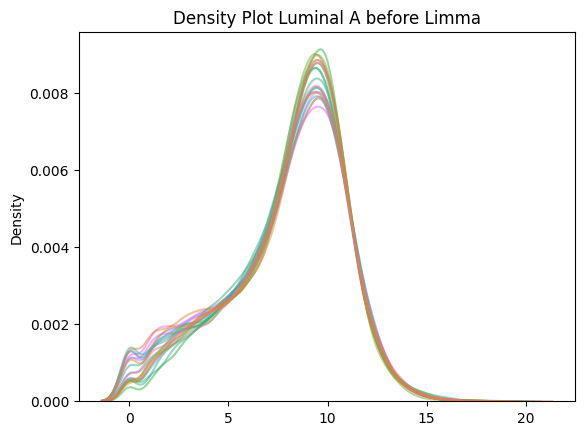

/Users/administrador/Desktop/UPSA4Año/Research_Investigation/UPSA_Thesis_Research/src/utils/plots.py:54: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



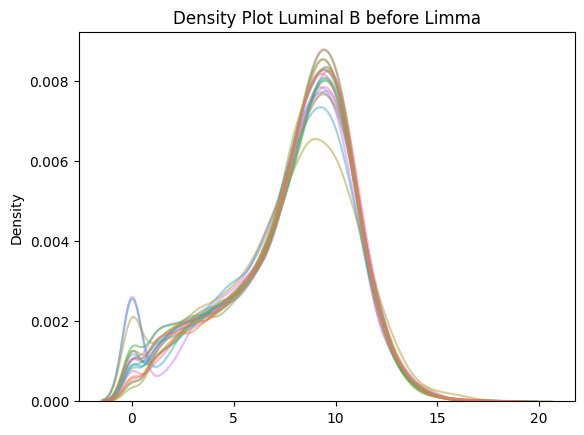

/Users/administrador/Desktop/UPSA4Año/Research_Investigation/UPSA_Thesis_Research/src/utils/plots.py:54: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



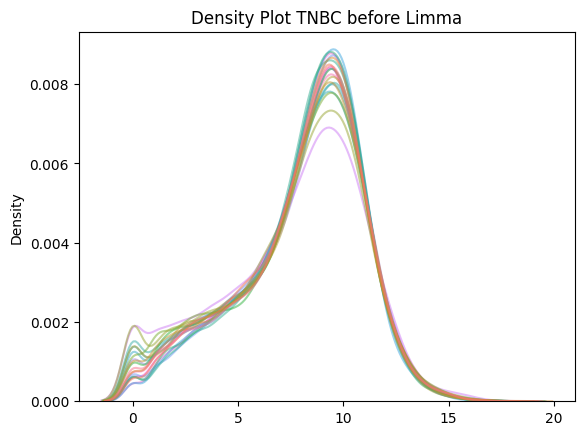

/Users/administrador/Desktop/UPSA4Año/Research_Investigation/UPSA_Thesis_Research/src/utils/plots.py:54: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



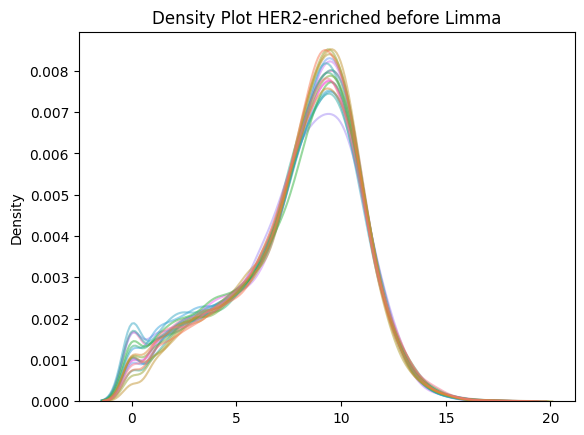

In [44]:

density_plot(data=zeros_reduced_df, title="Density Plot Luminal A before Limma",
         type_cancer="Luminal A", range_min=min_range,range_max=max_range)

density_plot(data=zeros_reduced_df, title="Density Plot Luminal B before Limma",
         type_cancer="Luminal B", range_min=min_range,range_max=max_range)

density_plot(data=zeros_reduced_df, title="Density Plot TNBC before Limma",
         type_cancer="TNBC", range_min=min_range,range_max=max_range)

density_plot(data=zeros_reduced_df, title="Density Plot HER2-enriched before Limma",
         type_cancer="HER2-enriched", range_min=min_range,range_max=max_range)


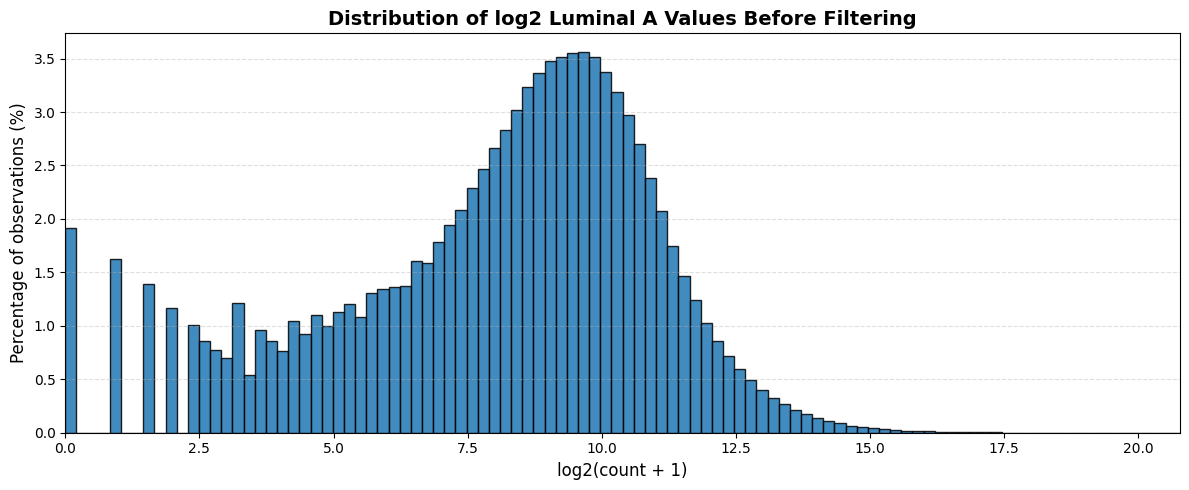

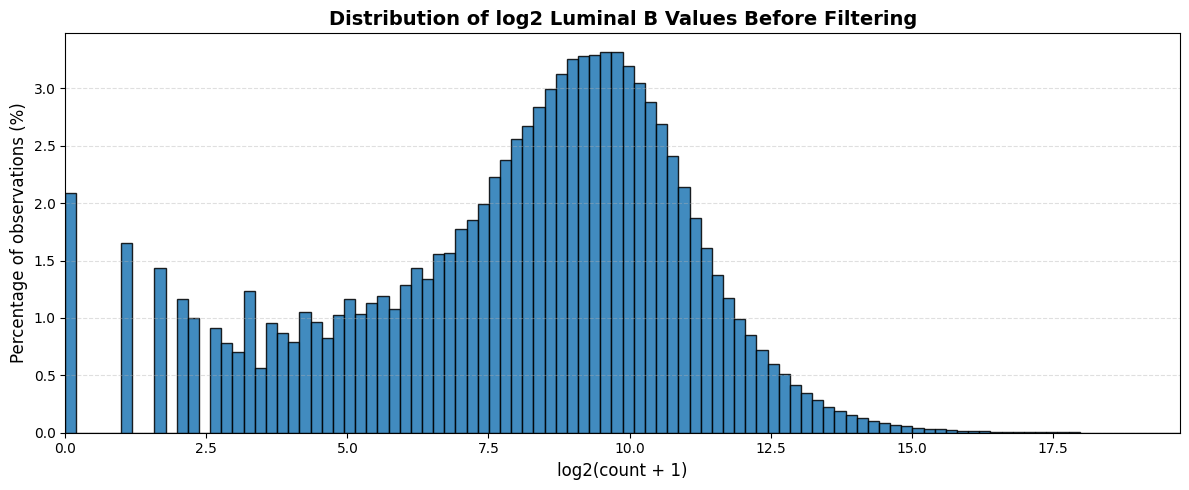

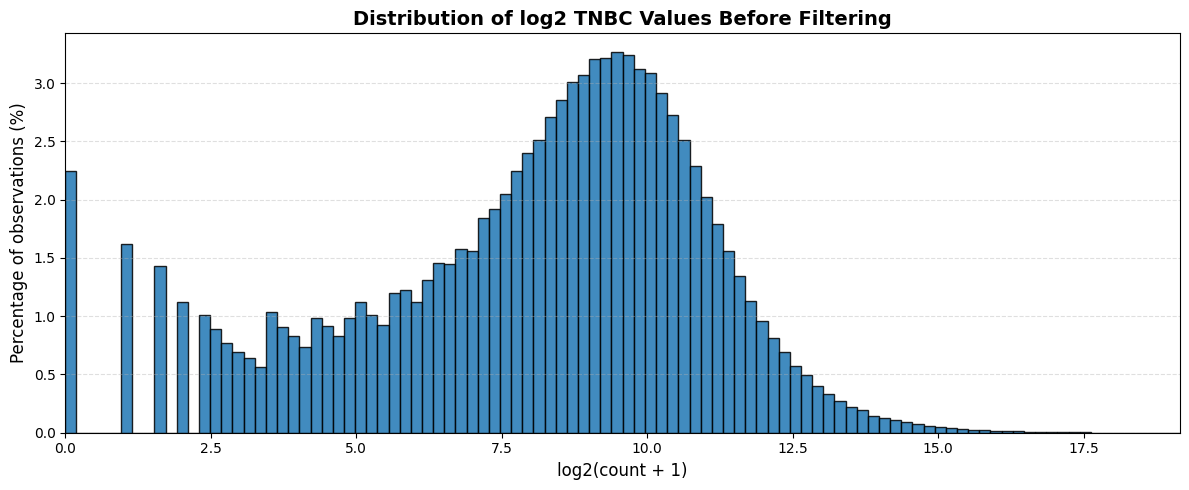

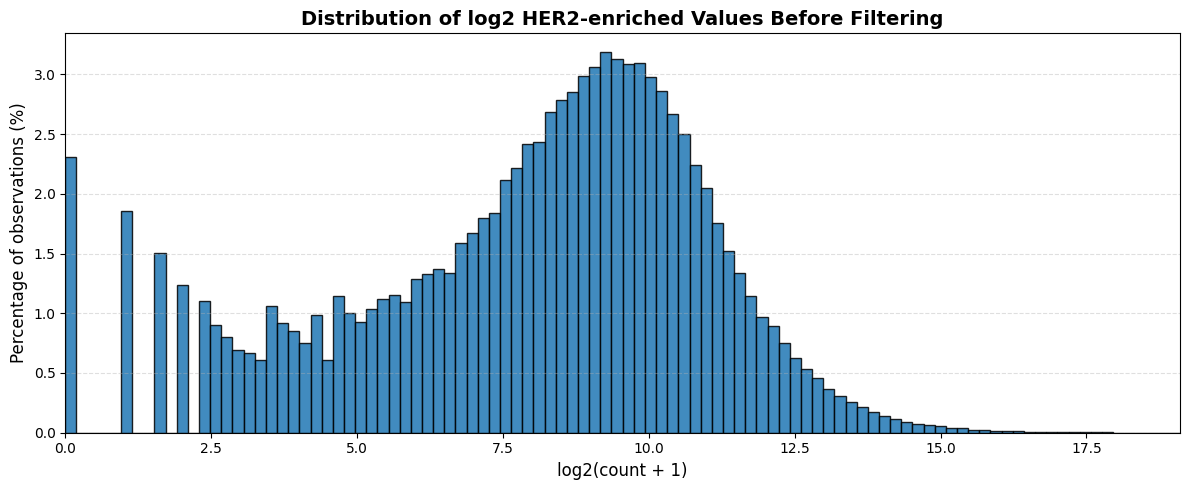

In [24]:
histogram_log2(df=zeros_reduced_df, title="Luminal A", type_cancer="Luminal A")
histogram_log2(df=zeros_reduced_df, title="Luminal B", type_cancer="Luminal B")
histogram_log2(df=zeros_reduced_df, title="TNBC", type_cancer="TNBC")
histogram_log2(df=zeros_reduced_df, title="HER2-enriched", type_cancer="HER2-enriched")

In [26]:
PCA_2_variables(df=zeros_reduced_df, cancer_type_one="Luminal A", cancer_type_two="Luminal B")

Split for making the Conditions for Deseq

In [28]:
PCA_variables_log2(df=zeros_reduced_df, cancer_types=["Luminal A", "Luminal B", "TNBC", "HER2-enriched"])

In [29]:
PCA_4_scatter_matrix_log2(df=zeros_reduced_df, cancer_types=["Luminal A", "Luminal B", "TNBC", "HER2-enriched"])

Initialization variables to enter into DeseqDataSet

In [30]:
metadata = pd.DataFrame(zeros_reduced_df["Tumor-Cancer"], index=zeros_reduced_df.index)
metadata.columns = ["Tumor_Cancer"]
counts_data = zeros_reduced_df.drop(columns=["Tumor-Cancer"])

metadata["Tumor_Cancer"]

2      Luminal A
6      Luminal A
7           TNBC
8      Luminal B
10          TNBC
         ...    
812    Luminal A
813    Luminal A
814         TNBC
815    Luminal A
816    Luminal A
Name: Tumor_Cancer, Length: 519, dtype: object

In [32]:
deseqDataSet_variable = initialize_DeseqDataSet(counts_data=counts_data,
                                                metadata=metadata,
                                                design="Tumor_Cancer")
deseqDataSet_variable.deseq2()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/functools.py:909: ImplicitModificationWarning:

Transforming to str index.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/functools.py:909: ImplicitModificationWarning:

Transforming to str index.

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.44 seconds.

Fitting dispersions...
... done in 20.16 seconds.

Fitting dispersion trend curve...
... done in 0.39 seconds.

Fitting MAP dispersions...
... done in 19.65 seconds.

Fitting LFCs...
... done in 10.73 seconds.

Calculating cook's distance...
... done in 0.65 seconds.

Replacing 786 outlier genes.

Fitting dispersions...
... done in 1.07 seconds.

Fitting MAP dispersions...
... done in 1.16 seconds.

Fitting LFCs...
... done in 0.94 seconds.



In [33]:
print(deseqDataSet_variable.obs["Tumor_Cancer"].unique())

['Luminal A' 'TNBC' 'Luminal B' 'HER2-enriched']


Masks for working with Deseq2

In [34]:
mask_luminal_a = (metadata["Tumor_Cancer"] == "Luminal A") #Mask for Luminal A
mask_luminal_b = (metadata["Tumor_Cancer"] == "Luminal B") #Mask for Luminal B
mask_luminal_TNBC = (metadata["Tumor_Cancer"] == "TNBC") #Mask for TNBC
mask_luminal_HER2 = (metadata["Tumor_Cancer"] == "HER2-enriched") #Mask for HER2-enriched

In [35]:
norm_counts = deseqDataSet_variable.layers["normed_counts"]
normal_counts_luminal_A = norm_counts[mask_luminal_a]
normal_counts_luminal_B = norm_counts[mask_luminal_b]
normal_counts_luminal_TNBC = norm_counts[mask_luminal_TNBC]
normal_counts_luminal_HER2 = norm_counts[mask_luminal_HER2]
print(type(normal_counts_luminal_A))

<class 'numpy.ndarray'>


Box Plots After Normalization

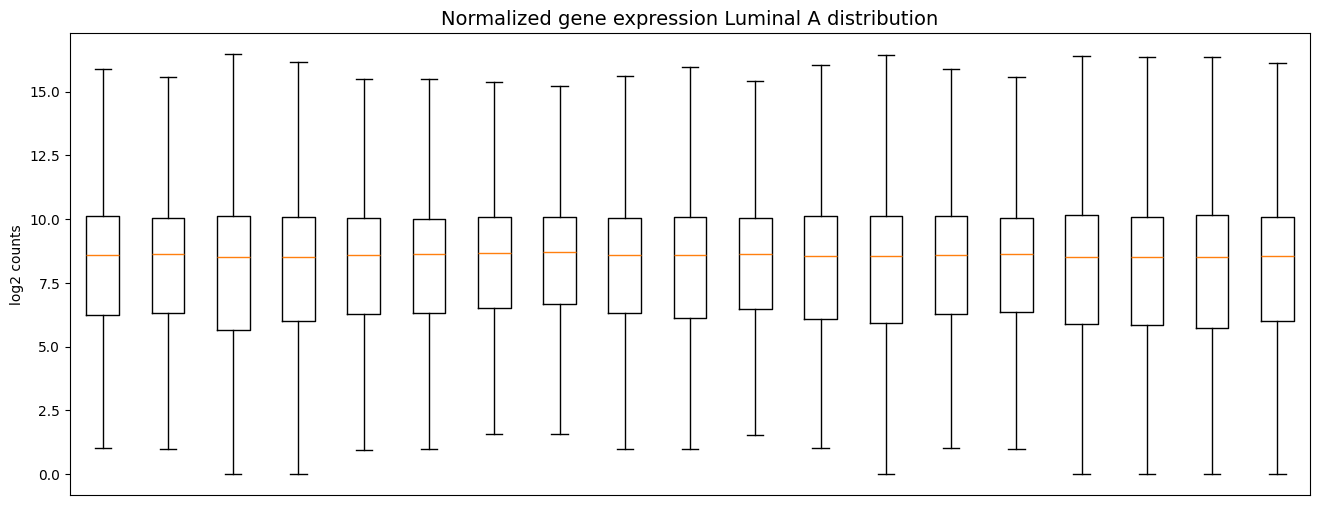

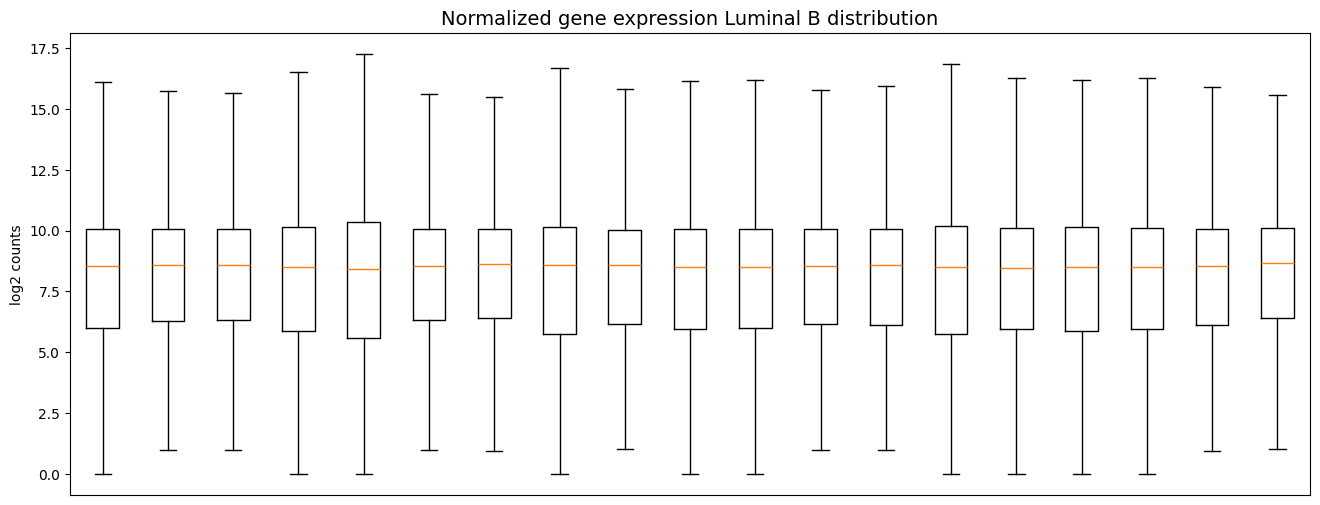

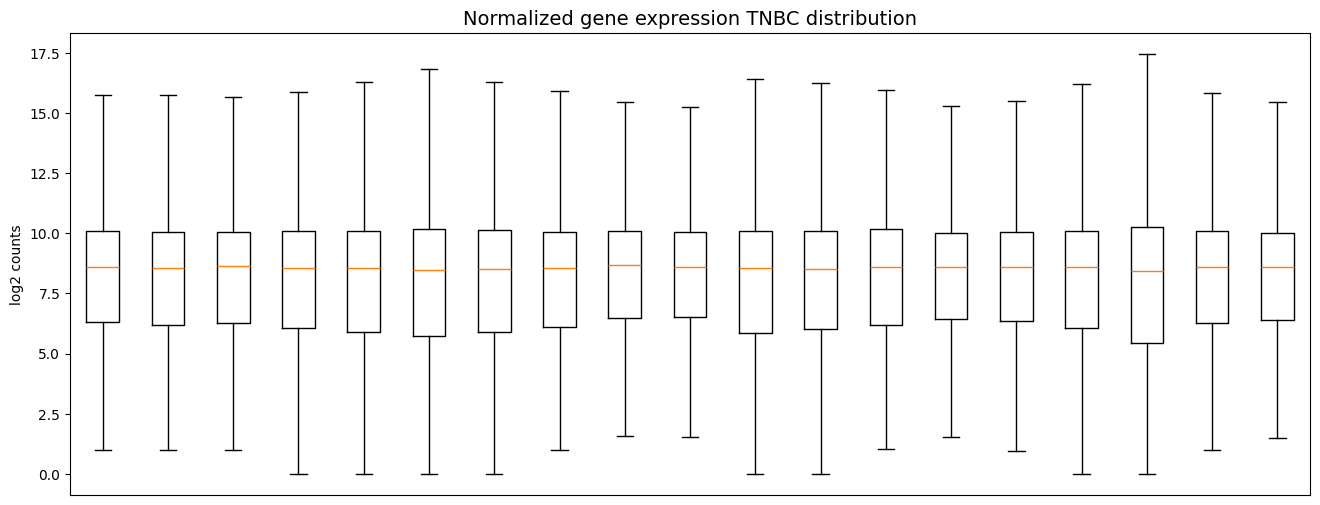

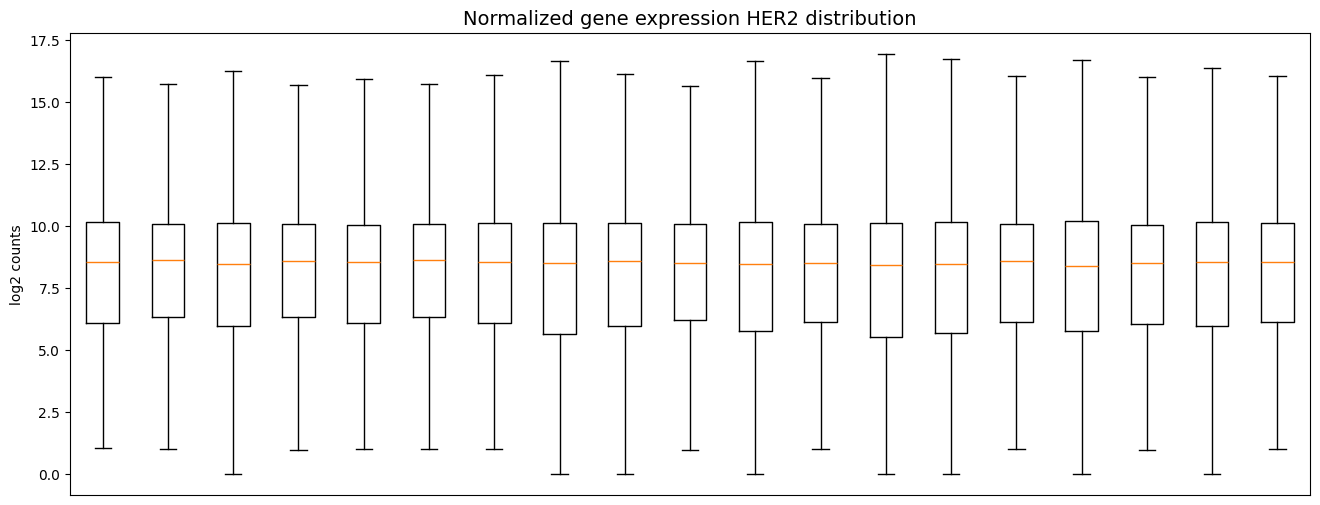

In [38]:
plt.figure(figsize=(16,6))
plt.boxplot(np.log2(normal_counts_luminal_A[1:20].T + 1), showfliers=False)
plt.xticks([])
plt.title("Normalized gene expression Luminal A distribution", fontsize=14)
plt.ylabel("log2 counts")
plt.show()



plt.figure(figsize=(16,6))
plt.boxplot(np.log2(normal_counts_luminal_B[1:20].T + 1), showfliers=False)
plt.xticks([])
plt.title("Normalized gene expression Luminal B distribution", fontsize=14)
plt.ylabel("log2 counts")
plt.show()



plt.figure(figsize=(16,6))
plt.boxplot(np.log2(normal_counts_luminal_TNBC[1:20].T + 1), showfliers=False)
plt.xticks([])
plt.title("Normalized gene expression TNBC distribution", fontsize=14)
plt.ylabel("log2 counts")
plt.show()



plt.figure(figsize=(16,6))
plt.boxplot(np.log2(normal_counts_luminal_HER2[1:20].T + 1), showfliers=False)
plt.xticks([])
plt.title("Normalized gene expression HER2 distribution", fontsize=14)
plt.ylabel("log2 counts")
plt.show()





/Users/administrador/Desktop/UPSA4Año/Research_Investigation/UPSA_Thesis_Research/src/utils/plots.py:54: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



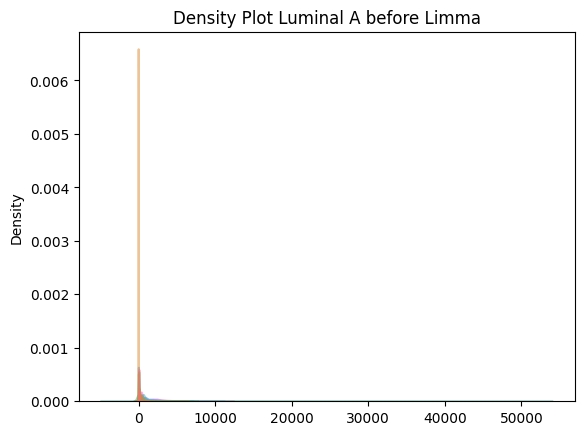

/Users/administrador/Desktop/UPSA4Año/Research_Investigation/UPSA_Thesis_Research/src/utils/plots.py:54: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



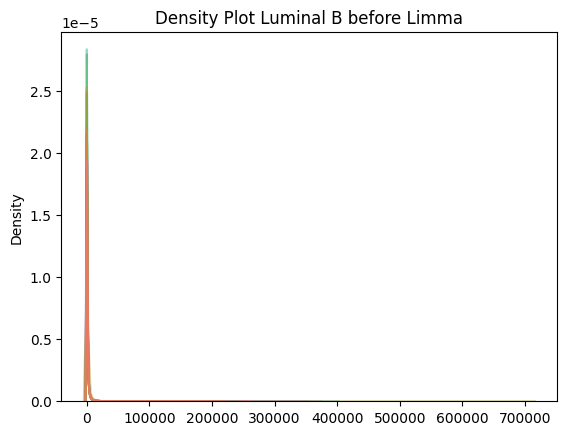

/Users/administrador/Desktop/UPSA4Año/Research_Investigation/UPSA_Thesis_Research/src/utils/plots.py:54: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



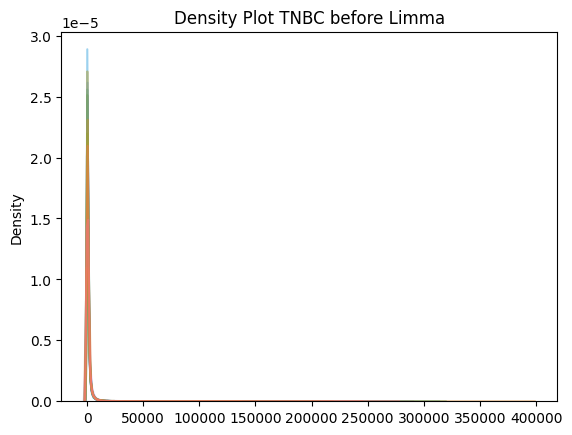

/Users/administrador/Desktop/UPSA4Año/Research_Investigation/UPSA_Thesis_Research/src/utils/plots.py:54: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



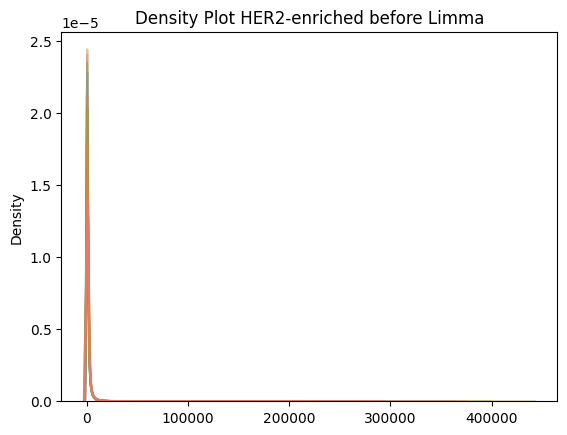

In [ ]:
density_plot(data=normal_counts_luminal_A, title="Density Plot Luminal A before Limma",
         type_cancer="Luminal A", range_min=min_range,range_max=max_range)

density_plot(data=normal_counts_luminal_B, title="Density Plot Luminal B before Limma",
         type_cancer="Luminal B", range_min=min_range,range_max=max_range)

density_plot(data=normal_counts_luminal_TNBC, title="Density Plot TNBC before Limma",
         type_cancer="TNBC", range_min=min_range,range_max=max_range)

density_plot(data=normal_counts_luminal_HER2, title="Density Plot HER2-enriched before Limma",
         type_cancer="HER2-enriched", range_min=min_range,range_max=max_range)


Histograms after the initialization

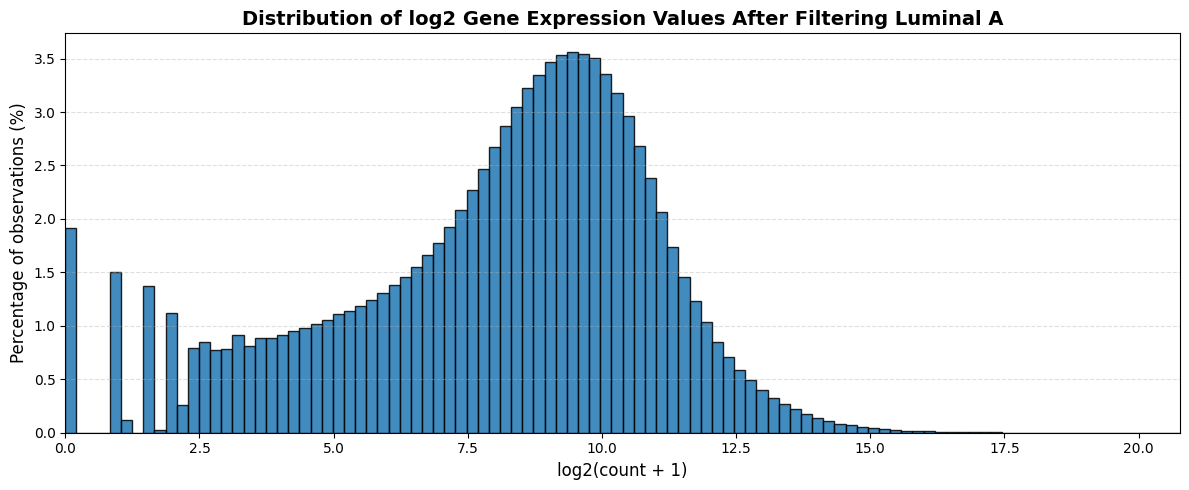

In [39]:
x = np.log2(normal_counts_luminal_A.ravel() + 1) # type: ignore
counts, bins = np.histogram(x, bins=100)
counts_percentage = (counts / counts.sum()) * 100
bin_width = bins[1] - bins[0]

plt.figure(figsize=(12,5))

plt.bar(
    bins[:-1],
    counts_percentage,
    width=bin_width,
    edgecolor="black",
    alpha=0.85,
    align="edge"
)
plt.title(
    "Distribution of log2 Gene Expression Values After Filtering Luminal A",
    fontsize=14,
    fontweight="bold"
)

plt.xlabel("log2(count + 1)", fontsize=12)
plt.ylabel("Percentage of observations (%)", fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.xlim(0, np.max(bins))
plt.tight_layout()

plt.show()

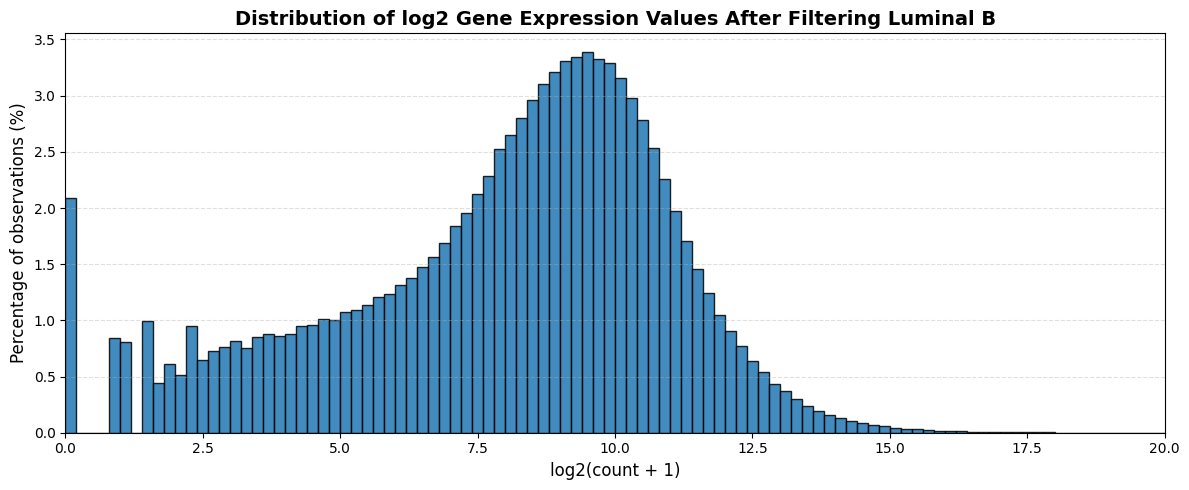

In [40]:
x = np.log2(normal_counts_luminal_B.ravel() + 1) # type: ignore
counts, bins = np.histogram(x, bins=100)
counts_percentage = (counts / counts.sum()) * 100
bin_width = bins[1] - bins[0]

plt.figure(figsize=(12,5))

plt.bar(
    bins[:-1],
    counts_percentage,
    width=bin_width,
    edgecolor="black",
    alpha=0.85,
    align="edge"
)
plt.title(
    "Distribution of log2 Gene Expression Values After Filtering Luminal B",
    fontsize=14,
    fontweight="bold"
)

plt.xlabel("log2(count + 1)", fontsize=12)
plt.ylabel("Percentage of observations (%)", fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.xlim(0, np.max(bins))
plt.tight_layout()

plt.show()

In [41]:
mask_a = np.asarray(mask_luminal_a)   # (n_samples,)
mask_b = np.asarray(mask_luminal_b) # (n_samples,)
mask_c = np.asarray(mask_luminal_TNBC)
mask_d = np.asarray(mask_luminal_HER2)

Xa = norm_counts[mask_a, :]  # Luminal A
Xb = norm_counts[mask_b, :]  # Luminal B
Xc = norm_counts[mask_c, :]  # TNBC
Xd = norm_counts[mask_d, :]  # HER2


X = np.vstack([Xa, Xb, Xc, Xd])
y = np.array(["Luminal A"] * Xa.shape[0] + ["Luminal B"] * Xb.shape[0] + ["TNBC"] * Xc.shape[0] + ["HER2-enriched"] * Xd.shape[0])


X_log = np.log2(X + 1)
X_scaled = StandardScaler().fit_transform(X_log)


pca = PCA(n_components=4, random_state=0)
components = pca.fit_transform(X_scaled)


df_plot = pd.DataFrame(components, columns=["PC1", "PC2", "PC3", "PC4"])
df_plot["Subtype"] = y

labels = {
        "PC1": f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)",
        "PC2": f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)",
        "PC3": f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)",
        "PC4": f"PC4 ({pca.explained_variance_ratio_[3]*100:.1f}%)",
    }


fig = px.scatter_matrix(
        df_plot,
        dimensions=["PC1", "PC2", "PC3", "PC4"],
        labels=labels,
        color="Subtype",
        title=f"PCA de Subtypes of cancer of mama with Log2 Luminal A, Luminal B,TNBC,HER2-enriched",
        opacity=0.7,
        color_discrete_map={"Luminal A": "#1f77b4",
                            "Luminal B": "#ec3204",
                            "TNBC": "#49fa09",
                            "HER2-enriched": "#fa09fa"},
)
fig.show()

In [52]:
inference = DefaultInference(n_cpus=2)
deseq_stats_test = DeseqStats(deseqDataSet_variable, contrast=["Tumor_Cancer", "Luminal A", "Luminal B","TNBC", "HER2-enriched"], inference=inference)

Running Wald tests...
... done in 9.11 seconds.



Log2 fold change & Wald test p-value: Tumor_Cancer Luminal A vs Luminal B
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0         6.615494       -0.132827  0.128724 -1.031875  0.302131  0.563708
1       118.652339       -0.013122  0.073407 -0.178762  0.858124  1.000000
2       213.092762        0.222426  0.113944  1.952070  0.050930  0.169916
7         5.650794        0.085728  0.100618  0.000000  1.000000  1.000000
14      413.575937       -0.026989  0.146982 -0.183618  0.854313  1.000000
...            ...             ...       ...       ...       ...       ...
20434   926.767624        0.031231  0.055613  0.561586  0.574398  0.826298
20435  3767.307800       -0.099277  0.077766 -1.276608  0.201741  0.435930
20436  1273.688628        0.171655  0.067790  2.532149  0.011337  0.057376
20437   982.078337        0.158323  0.070625  1.063038  0.287765  0.546602
20438   194.694506       -0.189725  0.229647 -0.826162  0.408712  0.677122

[16269 rows x 6 columns]


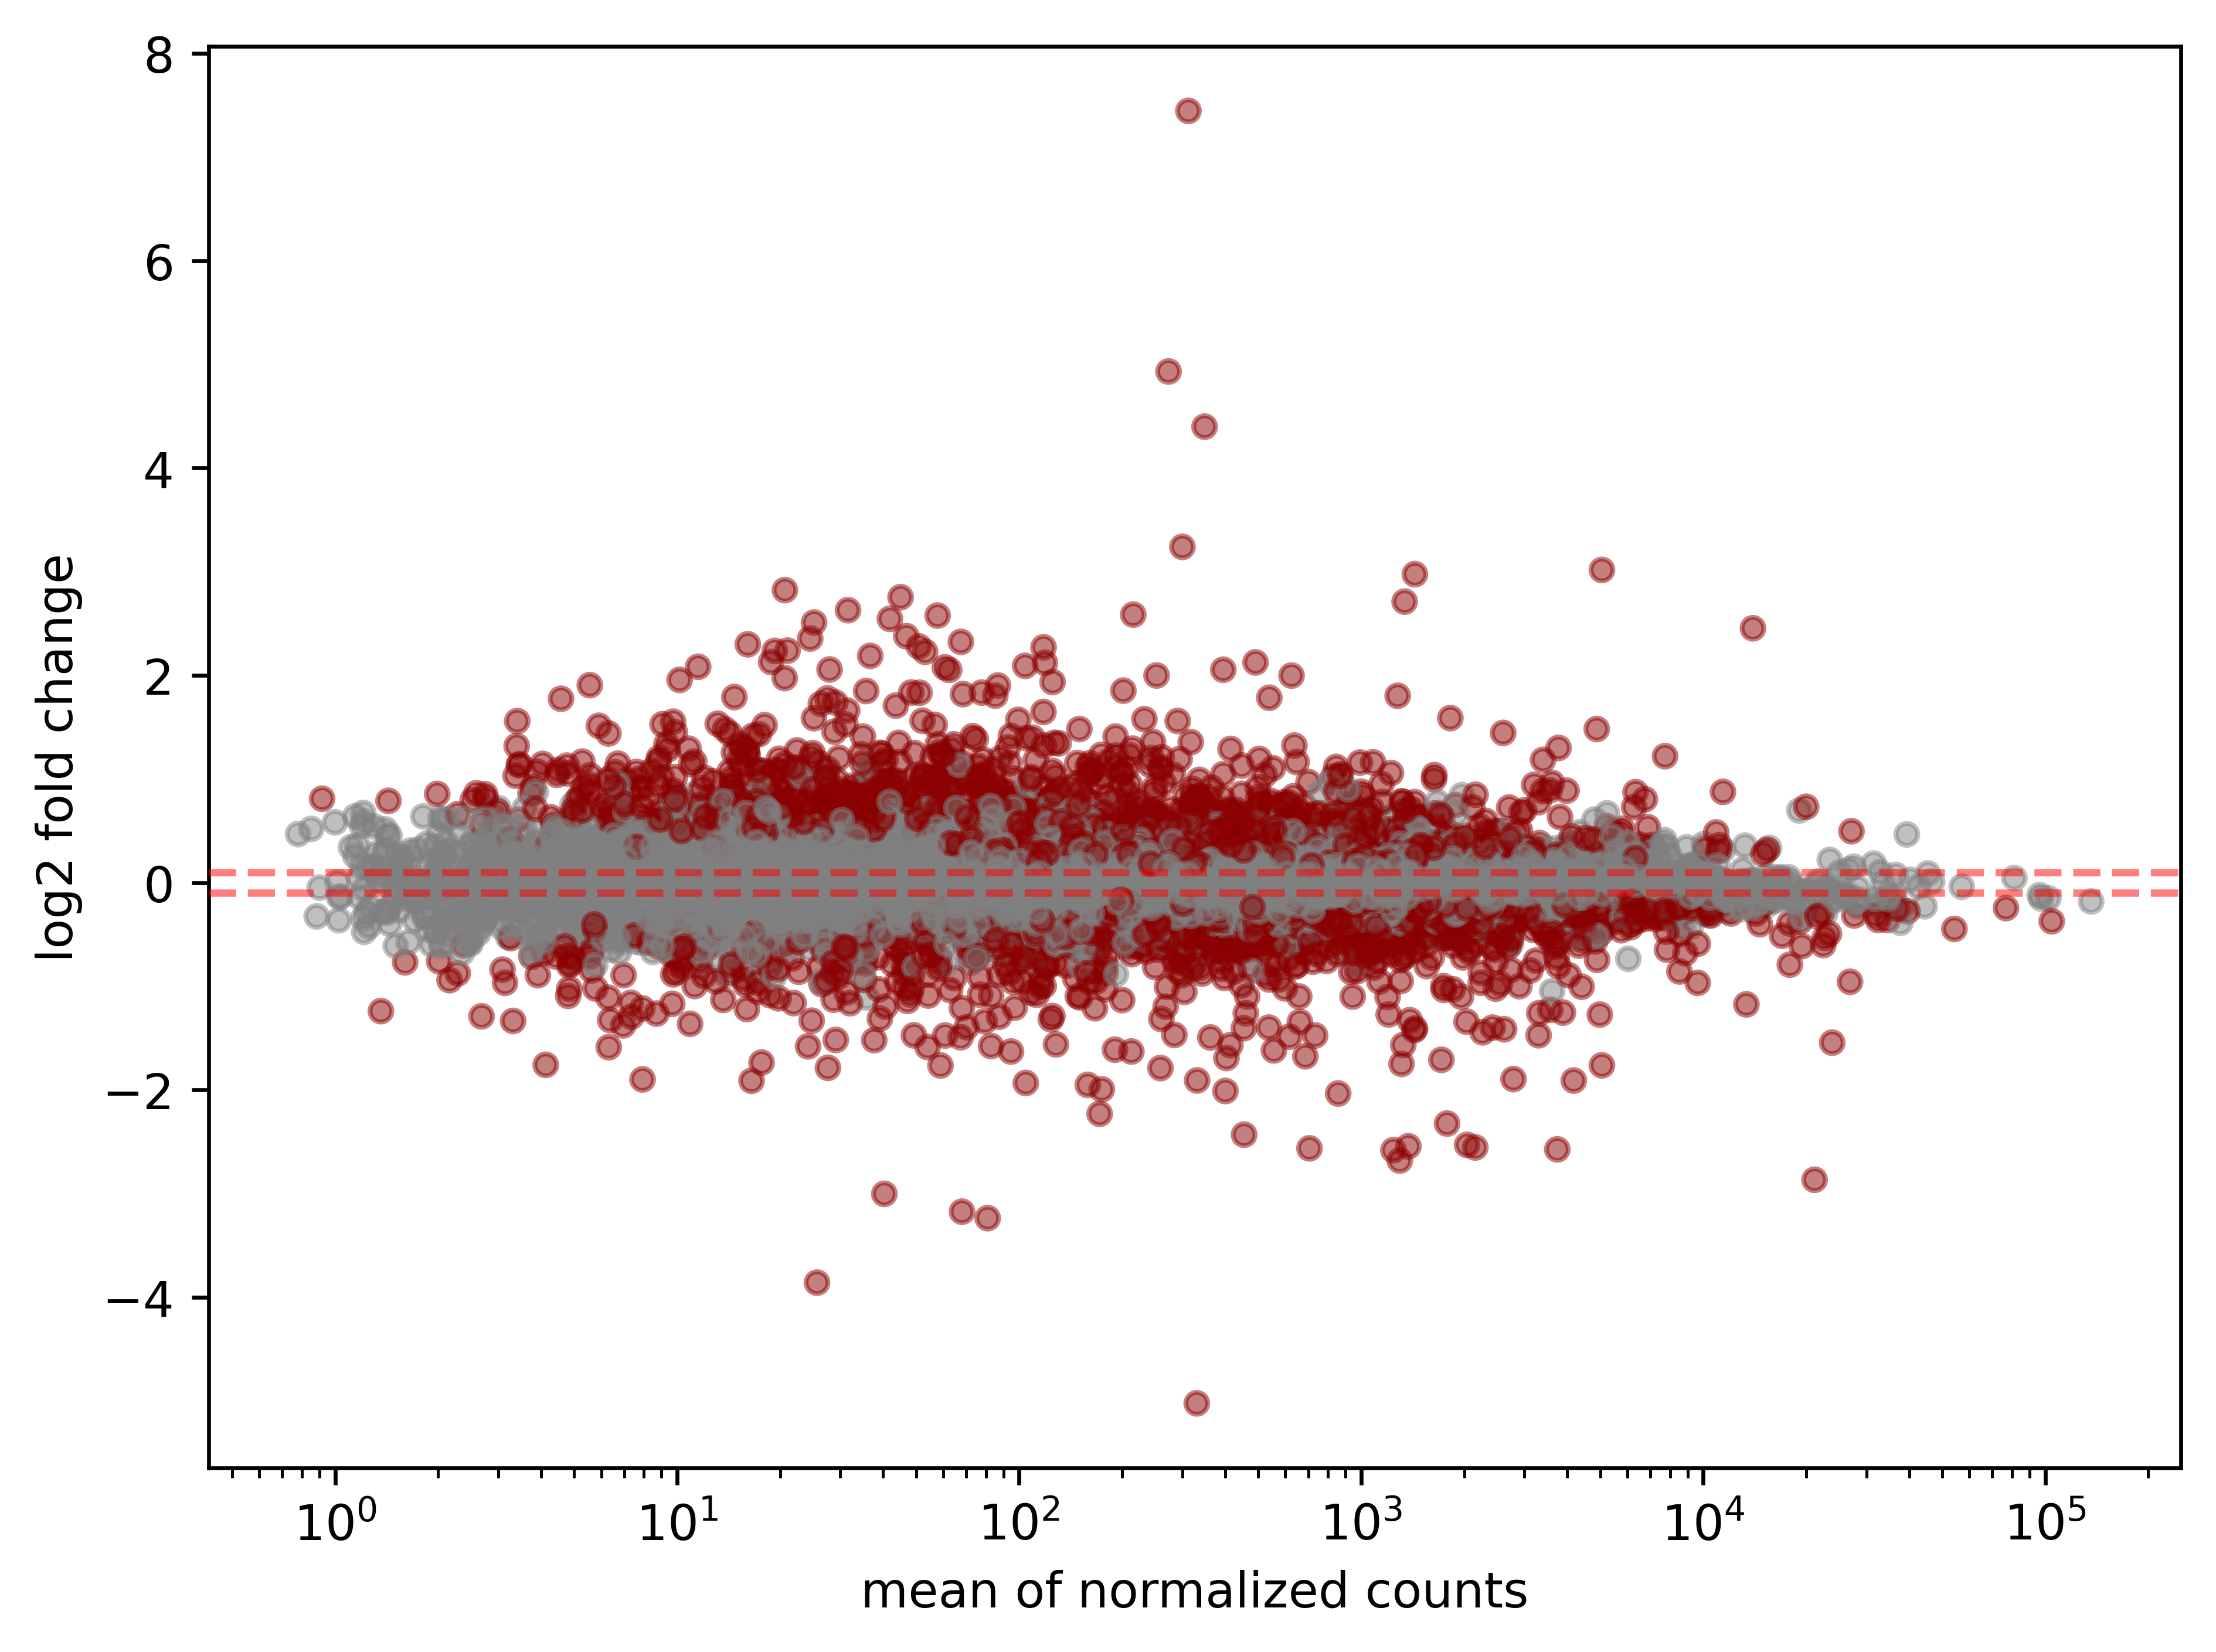

In [53]:
deseq_stats_test.summary(lfc_null=0.1, alt_hypothesis="greaterAbs")
deseq_stats_test.plot_MA(s=20)

In [55]:
print(type(deseqDataSet_variable))
deseqDataSet_variable_df = pd.DataFrame(deseqDataSet_variable.layers["normed_counts"])
print(type(deseqDataSet_variable_df))



<class 'pydeseq2.dds.DeseqDataSet'>
<class 'pandas.core.frame.DataFrame'>


In [56]:
deseqDataSet_variable_df

,0,1,2,3,4,5,6,7,8,9,...,16259,16260,16261,16262,16263,16264,16265,16266,16267,16268
0,3.894432,148.962010,72.046985,4.868040,291.108765,463.437364,97.360791,186.932718,68.152554,0.000000,...,788.622406,92.492751,706.839342,991.132851,55.495651,934.663592,2927.638981,901.560923,1046.628502,843.144449
1,4.033554,135.124060,63.528476,4.033554,641.335093,394.279908,4.033554,227.895803,131.090506,0.000000,...,423.523174,83.696246,2753.909022,840.996018,51.427814,1101.160253,3057.433963,966.036193,724.022950,43.360706
2,28.411420,1135.442112,168.439134,3.044081,68.999163,334.848880,7.102855,87.263648,409.936205,24.352646,...,1719.905611,70.013857,618.963081,1801.081098,160.321585,1400.277135,599.683903,1824.419050,1354.615924,49.719985
3,7.093909,120.596459,81.073250,5.067078,185.455058,502.654147,26.348806,311.118595,103.368393,0.000000,...,511.774888,60.804937,553.324928,1027.603438,39.523209,1428.916023,4631.309380,1197.857262,1473.506310,1184.682859
4,8.721900,184.129009,135.674006,4.845500,66.867903,317.864815,6.783700,34.887602,62.022403,826.642338,...,1265.644659,25.196601,282.977213,1007.864047,233.553111,659.957131,3365.684456,698.721132,1370.307463,14.536501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,6.835228,146.469177,527.289039,5.858767,211.892077,607.358856,61.517055,353.478948,140.610410,0.976461,...,287.079588,77.140433,432.572304,1057.507461,39.058447,837.803695,4813.953632,2159.932137,649.346687,243.138835
515,1.993579,114.630786,336.914832,3.987158,400.709356,939.972445,17.942210,50.836262,159.486311,0.000000,...,534.279141,44.855525,744.601714,900.100867,9.967894,631.964507,4149.634452,1246.983593,770.518239,4.983947
516,0.969509,153.182457,203.596937,1.939018,236.560250,485.724120,4.847546,200.688409,84.347302,792.089035,...,467.303445,59.140063,323.816080,904.552104,199.718900,464.394917,6419.120560,629.211485,756.217193,45.566933
517,4.915252,121.898249,317.525278,4.915252,1119.694400,533.796365,21.627109,262.474456,38.338965,1.966101,...,457.118434,44.237268,783.491165,1020.406310,12.779655,671.423420,5127.590863,1384.134957,700.914932,557.389574


In [57]:
z_counts = deseqDataSet_variable_df.apply(zscore, axis=1) # type: ignore
print(z_counts)

        0         1         2         3         4         5         6      \
0   -0.287923 -0.250719 -0.270445 -0.287673 -0.214265 -0.170070 -0.263953   
1   -0.335205 -0.298892 -0.318725 -0.335205 -0.158667 -0.227104 -0.335205   
2   -0.281486 -0.011418 -0.247325 -0.287674 -0.271584 -0.206728 -0.286684   
3   -0.210250 -0.192274 -0.198533 -0.210571 -0.182002 -0.131764 -0.207200   
4   -0.286953 -0.244028 -0.255886 -0.287902 -0.272724 -0.211301 -0.287428   
..        ...       ...       ...       ...       ...       ...       ...   
514 -0.253825 -0.222175 -0.135860 -0.254046 -0.207347 -0.117711 -0.241431   
515 -0.155633 -0.140137 -0.109556 -0.155359 -0.100779 -0.026589 -0.153439   
516 -0.292276 -0.253048 -0.240055 -0.292026 -0.231559 -0.167344 -0.291277   
517 -0.332653 -0.297135 -0.237740 -0.332653  0.005809 -0.172078 -0.327579   
518 -0.283805 -0.256936 -0.138921 -0.284332 -0.001677 -0.053044 -0.240867   

        7         8         9      ...     16259     16260     16261  \
0  

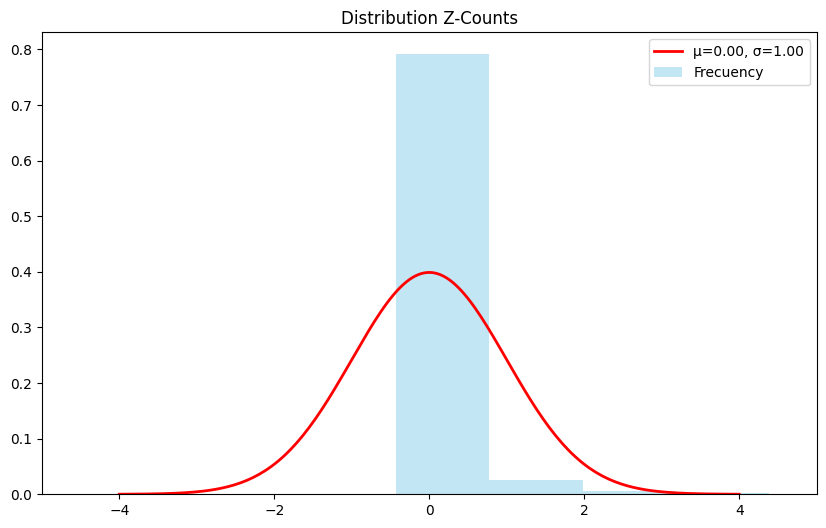

In [58]:
data = z_counts.values.ravel()


mu = np.nanmean(data) 
std = np.nanstd(data)

counts, bins = np.histogram(data, bins=100, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(10, 6))
plt.bar(bin_centers, counts, width=(bins[1]-bins[0]), color='skyblue', alpha=0.5, label='Frecuency')

x = np.linspace(mu - 4*std, mu + 4*std, 200)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', lw=2, label=f'μ={mu:.2f}, σ={std:.2f}')

plt.title("Distribution Z-Counts")
plt.xlim(-5, 5)
plt.legend()
plt.show()

In [59]:
upper_outliers = np.sum(data > 3)
down_outliers = np.sum(data < -3)
total = len(data)
print(f"total of data: {total}")
print(f"Outliers Upper (>3): {upper_outliers} ({100*upper_outliers/total:.4f}%)")
print(f"Outliers Down (<-3): {down_outliers} ({100*down_outliers/total:.4f}%)")

total of data: 8443611
Outliers Upper (>3): 74294 (0.8799%)
Outliers Down (<-3): 0 (0.0000%)
